# Dauphine 203 - Machine learning competition: Predict emerging countries corporates default risk

## Part 1: Exploratory Data Analysis and Feature Engineering

***

## Motivation

**Corporates default risk prediction**

*For the last century, corporate default risk prediction has been a main concern to financial market analysts. Nowadays, it stills ranks high among topics in economics. Using machine learning and data-driven approaches, it is now possible to build more robust models to predict financial distress. The aim of this competition is to develop a bankruptcy predictive model based on corporate econometric and financial measures.*

**Available Data**

*Data consists of 10503 eastern Europe bankrupted and still operating corporate from manufacturing sector. For each corporate is provided 62 econometrics and financial standardized rates. Competitors are asked to predict companies financial state in 3 years.*

**Objective**

*Train the best machine learning algorithm to model the underlying relationship between year N economics and financial measures and corporate financial state at year N+3.*

**Syllabus**

1. Exploratory data analysis
2. Feature engineering
3. Model selection
4. Model review and interpretation
5. Kaggle submission

***

## <font color='red'> 1. Exploratory data analysis </font>

### <font color='green'> 1.1. Loading the dataset </font>

We start by loading the dataset of Eastern European companies:

In [1]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from copy import copy
import missingno as msno

In [2]:
# Load dataset
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv', index_col=0)
features_abv = df_train.drop('label', axis=1).columns
indices = pd.read_csv('train.csv')['id']
indices_test = pd.read_csv('test.csv')['id']

# Feature description
features_descrip = pd.read_csv('descrip.csv', encoding = "ISO-8859-1", header=None)

def split_features(df):
    features_c = copy(df)
    for i in range(len(df)):
        x = features_c.iloc[i,0].split('-', 1)
        features_c.iloc[i,0] = x[1]
    return features_c

descrip = split_features(features_descrip)
descrip['code'] = features_abv
descrip.columns = ['des','code']

# Initial cleaning (I don't remove labels yet in the case
# we drop features or training examples due to NaN values)
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

print('Train:', df_train.shape)
print('Test:', df_test.shape)
df_train.head()

Train: (7037, 63)
Test: (3466, 62)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f56,f57,f58,f59,f60,f61,f62,f63,f64,label
0,0.003603,0.824060,-0.049051,0.89208,-111.350,0.00000,0.008453,0.21344,0.87744,0.17589,...,0.030310,0.020487,0.94317,1.47710,4.6339,6.9992,189.060,1.9306,1.4759,1
1,0.131870,0.682830,0.235280,1.41050,-122.380,0.00000,0.131870,0.46450,1.73390,0.31717,...,0.263240,0.415770,0.73676,0.34571,2.9030,12.4490,120.660,3.0251,9.0520,0
2,0.289520,0.902560,0.087251,1.09670,10.167,-0.56967,0.289520,0.10796,3.28730,0.09744,...,0.088068,2.971200,0.91193,0.00000,NaN,44.8260,100.210,3.6422,322.6400,0
3,-0.145210,0.053488,0.688930,13.88000,107.670,0.66483,-0.145210,17.69600,1.66640,0.94651,...,-0.109730,-0.153420,1.07670,0.00000,11.6370,11.6090,11.716,31.1540,6.4692,0
4,0.033186,0.420470,0.543820,2.29330,38.452,0.00000,0.062227,1.37830,5.04240,0.57953,...,0.021615,0.057263,0.98766,0.00000,NaN,9.8313,30.436,11.9920,141.2000,0


### <font color='green'> 1.2. Taking a quick look at the dataset <font>

Let's look at a description of our dataset:

In [3]:
pd.set_option("display.max_columns", 100)
df_train.describe().round(2)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f22,f23,f24,f25,f26,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,label
count,7037.00,7037.00,7037.00,7021.00,7028.00,7037.00,7037.00,7024.00,7035.00,7037.00,7037.00,7021.00,7008.00,7037.00,7030.00,7024.00,7024.00,7037.00,7008.00,7008.00,7037.00,7008.00,6886.00,7037.00,7024.00,6879.00,7037.00,7008.00,7008.00,6977.00,7021.00,7024.00,7037.00,7037.00,3835.00,7037.00,7008.00,7021.00,6908.00,7008.00,7008.00,7008.00,6631.00,7021.00,6985.00,7037.00,7008.00,7024.00,7037.00,6985.00,6879.00,6879.00,7037.00,7008.00,7037.00,7017.00,7037.00,6631.00,7024.00,7008.00,7021.00,6879.00,7037.00
mean,0.06,0.60,0.12,12.80,-1777.59,-0.09,0.07,18.46,1.85,0.39,0.09,2.07,0.63,0.07,1577.18,2.44,19.97,0.08,-0.14,68.33,0.08,-0.15,0.23,0.23,2.25,7.11,3.29,0.35,-0.15,1620.68,8.71,5.85,0.08,1.98,128.15,0.49,-0.11,2.66,42.64,-0.11,203.33,135.00,35.91,11.81,402.38,0.01,-0.17,11.33,0.48,4.42,6.54,7.68,1506.44,-0.80,-0.01,4.70,1.48,699.84,13.44,73.63,9.38,41.20,0.05
std,0.70,5.76,5.75,639.70,143393.25,6.19,0.71,738.02,8.99,5.76,0.71,93.52,60.19,0.71,45922.03,91.32,743.85,0.95,9.93,1142.93,0.66,9.88,2.43,6.02,88.72,111.21,0.84,86.37,9.85,83403.30,43.89,83.93,0.65,2.16,3010.09,5.75,9.82,44.38,3474.46,9.43,3657.78,3211.90,1850.06,639.59,22286.35,0.70,9.66,638.32,5.75,228.37,104.77,109.78,12865.48,68.38,22.48,227.28,91.24,45161.53,73.62,31448.78,35.64,511.48,0.21
min,-9.74,0.00,-479.73,0.00,-11903000.00,-508.12,-9.74,-2.08,-1.22,-479.73,-8.94,-1543.80,-557.01,-9.74,-2321800.00,-94.26,-0.04,-9.74,-576.12,-0.00,-9.74,-576.12,-60.74,-500.75,-94.26,-267.22,-0.97,-6351.70,-576.12,-270.71,-1.92,-1696.00,-5.51,-0.00,-2.20,-479.73,-551.11,-5.27,-216.82,-551.11,-25113.00,-25113.00,-3978.00,-4.22,-17.30,-9.74,-556.59,0.00,0.00,-0.52,-869.04,-268.67,-180331.20,-5691.70,-1667.30,-1.20,-172.07,0.00,-6.59,-2336500.00,-0.00,-0.00,0.00
25%,0.00,0.25,0.02,1.04,-51.96,0.00,0.00,0.43,1.01,0.30,0.01,0.00,0.02,0.00,174.89,0.06,1.45,0.00,0.00,14.20,0.00,0.00,0.01,0.14,0.05,0.03,2.76,0.07,0.00,44.61,2.78,0.37,0.00,1.04,1.08,0.43,0.00,0.05,0.02,0.00,65.12,34.16,0.01,0.60,14.90,-0.05,-0.04,0.75,0.18,0.12,0.67,0.95,2.88,0.00,0.01,0.87,0.00,5.52,4.49,40.52,3.03,2.03,0.00
50%,0.04,0.46,0.20,1.61,2.23,0.00,0.05,1.12,1.20,0.52,0.07,0.16,0.07,0.05,781.46,0.24,2.17,0.05,0.03,34.13,0.06,0.03,0.16,0.38,0.22,0.47,3.30,0.21,0.04,77.54,4.69,2.07,0.05,1.59,2.75,0.63,0.03,0.20,0.08,0.03,98.32,54.42,0.26,1.07,36.65,0.01,0.01,1.24,0.33,0.21,1.21,1.38,199.21,0.05,0.11,0.95,0.00,10.05,6.68,70.46,5.15,4.03,0.00
75%,0.13,0.69,0.42,2.96,56.91,0.07,0.14,2.85,2.06,0.73,0.16,0.58,0.14,0.14,2131.18,0.65,3.94,0.14,0.09,63.60,0.15,0.08,0.38,0.62,0.60,1.57,3.83,0.42,0.10,129.89,8.09,4.88,0.15,2.38,11.06,0.79,0.09,0.75,0.19,0.09,142.56,80.82,0.97,2.06,69.73,0.10,0.06,2.33,0.52,0.35,2.29,2.46,1021.61,0.13,0.27,1.00,0.24,21.10,10.63,119.16,8.94,9.67,0.00
max,52.65,480.73,17.71,53433.00,685440.00,45.53,52.65,53432.00,740.44,11.84,52.65,7022.60,4972.00,52.65,1379200.00,7022.60,53433.00,53.69,123.94,91600.00,47.60,123.94,179.92,8.83,7022.60,6233.30,9.00,2940.50,60.43,6674200.00,2787.90,6348.50,47.60,75.40,136090.00,13.66,293.15,2883.00,288770.00,165.95,254030.00,254030.00,113280.00,53433.00,1848800.00,47.60,178.89,53433.00,480.73,18285.00,6234.30,6234.30,636768.00,293.15,552.64,18118.00,7617.30,3660200.00,4246.70,1073500.00,1974.50,21499.00,1.00


In [4]:
pd.reset_option('display')

height has been deprecated.

line_width has been deprecated, use display.width instead (currently both are
identical)



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  """Entry point for launching an IPython kernel.


**Missing values** are a grave concern for any statistical model. We use functions from the `missingno` Python package to check for missing values in the training set. We find that a lot of columns have missing data.

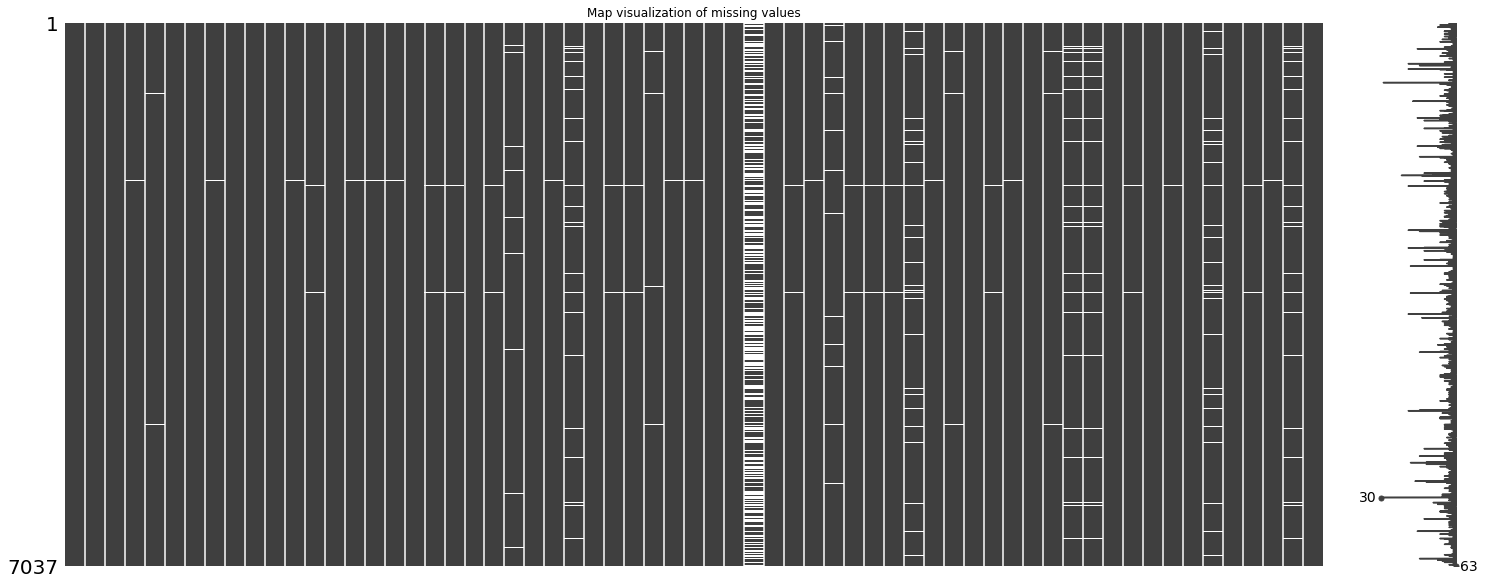

In [17]:
msno.matrix(df_train)
plt.title('Map visualization of missing values')
plt.show()

In [6]:
n_assets = len(df_train.drop('label', axis=1).columns)
NAs = pd.concat([df_train.isnull().sum(), df_train.isnull().sum()/n_assets, df_test.isnull().sum(),
                 df_test.isnull().sum()/n_assets], axis=1, keys=['Train', 'Train%', 'Test','Test%'])
NAs = NAs[NAs.sum(axis=1) > 0]
NAs = NAs.sort_values(by=['Train'], ascending=False)
print(len(NAs))
NAs[NAs['Train%']>5]  # We consider for now features with 5% NaN values

42


,Train,Train%,Test,Test%
f37,3202,51.645161,1534.0,24.741935
f45,406,6.548387,185.0,2.983871
f60,406,6.548387,186.0,3.000000


68% of the features from our dataset are contaminated with missing values.

In [7]:
print(len(NAs) / n_assets)

0.6774193548387096


Next, we consider the companies (rows) with NaN values.

In [8]:
def num_missing(x):
    return sum(x.isnull())

NA_rows = df_train.apply(num_missing, axis=1)
NA_rows_test = df_test.apply(num_missing, axis=1)

print('Firms with > 20 missing values:', len(NA_rows[NA_rows>20]))
print('Firms with > 10 missing values:', len(NA_rows[NA_rows>10]))
print('Firms with > 05 missing values:', len(NA_rows[NA_rows>5]))
print('Firms with missing values:', len(NA_rows[NA_rows>=1]))
print('Firms with missing values (test set):', len(NA_rows_test[NA_rows_test>=1]))

Firms with > 20 missing values: 10
Firms with > 10 missing values: 40
Firms with > 05 missing values: 110
Firms with missing values: 3455
Firms with missing values (test set): 1646


We also need to get an idea of the **class imbalance** in our training dataset, which is extremely skewed towards non-defaults (this is to be expected as defaults are rare events).

In [9]:
df_train['label'].value_counts() / len(df_train)

0    0.951684
1    0.048316
Name: label, dtype: float64

Finally, let's take a look at **data correlations**. We generate a heatmap of the correlations:

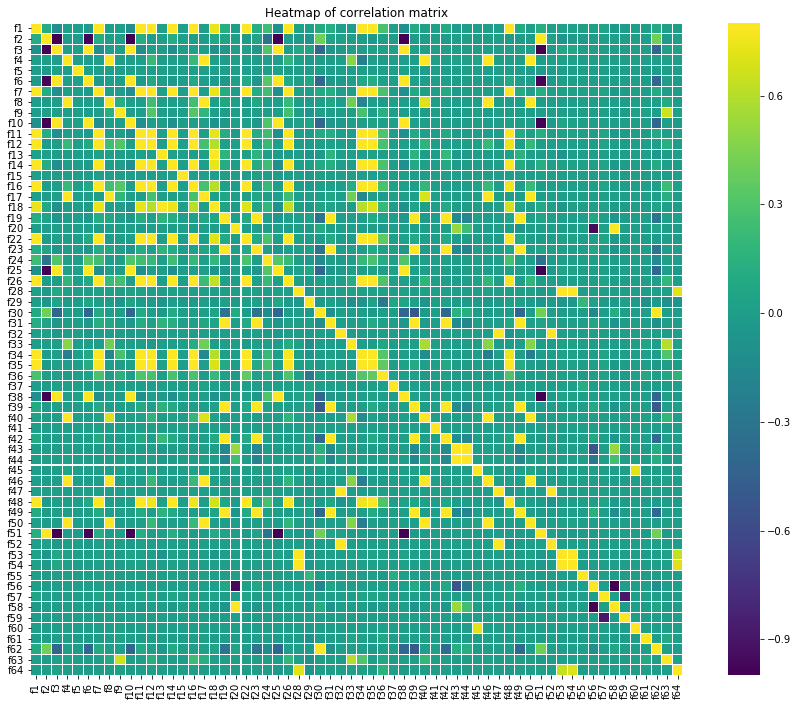

In [15]:
corrmat = df_train.drop(['label'], axis=1).corr()
plt.subplots(figsize=(16,12))
plt.title('Heatmap of correlation matrix')
sns.heatmap(corrmat, vmax=0.8, linewidths=0.01, square=True, cmap='viridis',linecolor="white")
sns.reset_orig()

# msno.heatmap(df_train.drop('label', axis=1))
# plt.show()

def get_top_correlations(df, n=5):
    
    def get_redundant_pairs(df):
        """
        Get diagonal and lower triangular pairs of correlation matrix
        """
        pairs_to_drop = set()
        cols = df.columns
        for i in range(0, df.shape[1]):
            for j in range(0, i+1):
                pairs_to_drop.add((cols[i], cols[j]))
        return pairs_to_drop
    
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# corrs = df_train.drop('label',axis=1).corr()
# corrs_rank = get_top_correlations(df_train.drop('label', axis=1), 400)
#print(corrs_rank.shape)
# corrs_rank[corrs_rank>0.8]

In [14]:
corr_labels = df_train.corr()
corr_labels['label'].sort_values(ascending=False)[0:10]

label    1.000000
f33      0.032930
f15      0.019507
f40      0.006202
f2       0.005458
f37      0.004981
f63      0.004831
f36      0.003601
f51      0.003178
f5       0.002677
Name: label, dtype: float64

### <font color='green'> 1.3. Data visualization <font>

In [13]:
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler

imputer = Imputer()
scaler = RobustScaler()

X_eda = copy(df_train)
X_eda = pd.DataFrame(X_eda, columns=df_train.columns)
X_eda = X_eda.drop('label', axis=1)

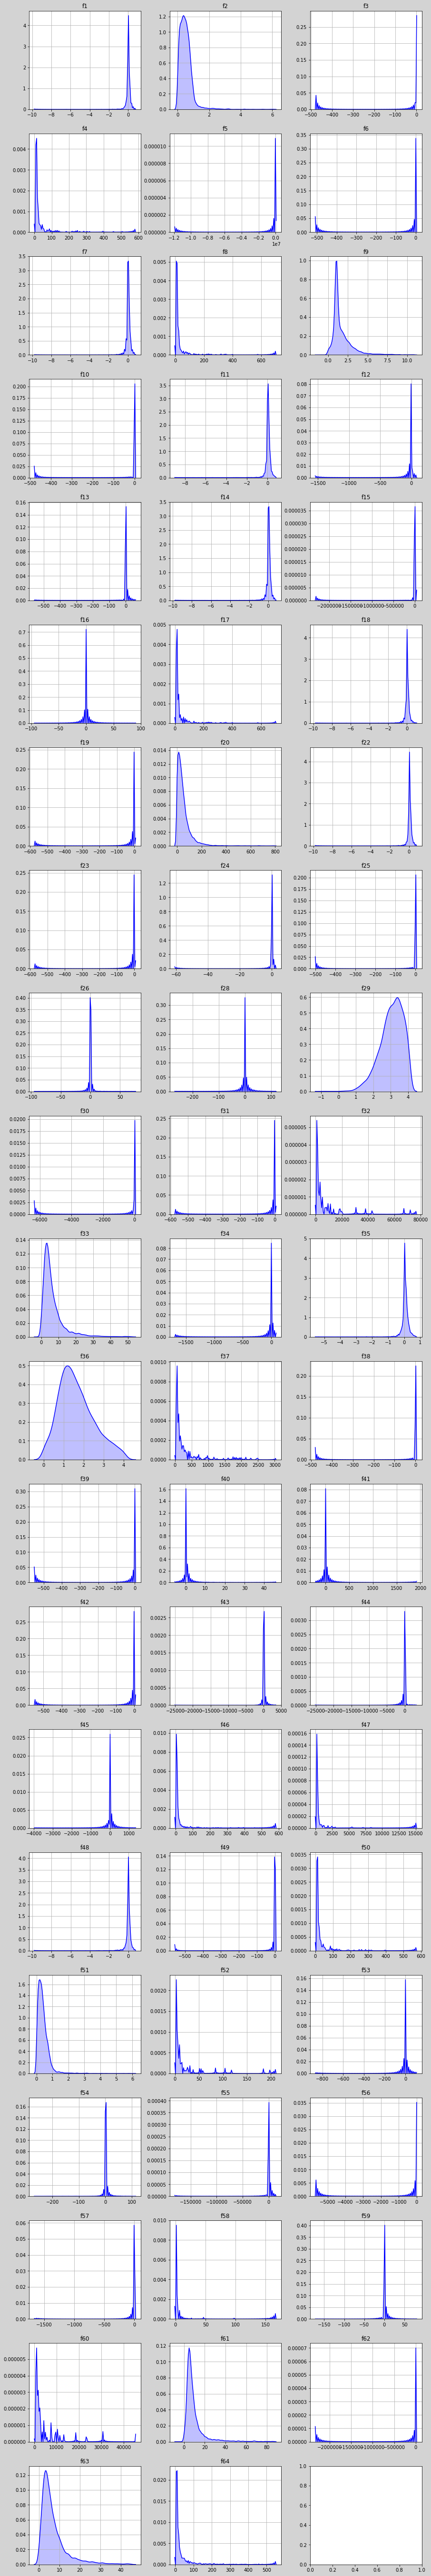

In [14]:
display = True
df_display = X_eda

if display==True:
    # Feature selection
    c = -1

    # Plot features
    fig, ax = plt.subplots(21, 3, figsize=(12,75), facecolor='lightgray')
    fig.tight_layout(pad=0.4, w_pad=3.0, h_pad=3.0)

    for i in range(21):
        for j in range(3):
            c = c + 1
            if c < len(X_eda.columns):
                col = X_eda.columns[c]

                #df_train[[col]].boxplot(grid=True, ax=ax[i,j])
                #df_train[col].hist(bins=50, color='blue', grid=True, edgecolor='black', ax=ax[i,j])
                
                temp_mean = df_train[col].mean()
                temp_std = df_train[col].std()
                
                temp_data = df_train[col][df_train[col] < temp_mean + 1*temp_std]
                sns.kdeplot(temp_data.values, color='blue', shade=True, ax=ax[i,j])
                
                #sns.boxplot(df_display[col].values, color='black', ax=ax[i,j])

                #df_train_0 = X_eda[col][X_eda['label']==0]
                #df_train_1 = X_eda[col][X_eda['label']==1]
                
                #labels_0 = X_eda['label'][X_eda['label']==0]
                #labels_1 = X_eda['label'][X_eda['label']==1]
                
                #sns.kdeplot(df_train_1, color='red', ax=ax[i,j], label='1 (Default)')
                #sns.kdeplot(df_train_0, color='green', ax=ax[i,j], label='0')
                #ax[i,j].scatter(df_train_0, labels_0, color="green", marker='x')
                #ax[i,j].scatter(df_train_1, labels_1, color="red", marker='x')
                
                #sns.boxplot(x='label', y=col, data=df_train, ax=ax[i,j])
                
                ax[i,j].grid(True)
                ax[i,j].set_title(col)

    sns.reset_orig()

We look to find features that truly discriminate between defaulted (class 1) and non-defaulted companies (class 0):

In [15]:
df_train_0 = df_train[df_train['label']==0]
df_train_1 = df_train[df_train['label']==1]

In [16]:
pd.set_option("display.max_colwidth", 90)
pd.set_option("display.max_rows", 101)

res = pd.DataFrame([df_train_0.mean(), df_train_0.std(), df_train_1.mean(), df_train_1.std()])
res = res.transpose()
res.columns = ['Mean (0)','Std (0)', 'Mean (1)', 'Std (1)']
res = res.reset_index()
res['description'] = descrip['des']            
res

,index,Mean (0),Std (0),Mean (1),Std (1),description
0,f1,0.062770,0.708202,-0.079003,0.590929,net profit / total assets
1,f2,0.588459,5.897785,0.734956,0.687161,total liabilities / total assets
2,f3,0.124556,5.894283,0.026029,0.473883,working capital / total assets
3,f4,13.126105,655.599252,6.449107,58.120966,current assets / short-term liabilities
4,f5,-1864.138939,146992.913528,-75.174655,367.189045,[(cash + short-term securities + receivables - short-term liabilities) / (operating e...
5,f6,-0.088564,6.342226,-0.162938,0.525574,retained earnings / total assets
6,f7,0.075822,0.711021,-0.070429,0.595298,EBIT / total assets
7,f8,19.137377,756.414581,5.063139,50.991982,book value of equity / total liabilities
8,f9,1.856227,9.202706,1.744440,1.634697,sales / total assets
9,f10,0.398704,5.900730,0.247051,0.689171,equity / total assets


In [16]:
pd.reset_option('display')

height has been deprecated.

line_width has been deprecated, use display.width instead (currently both are
identical)



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  """Entry point for launching an IPython kernel.


## <font color='red'> 2. Features engineering <font>

### <font color='green'> 2.1. Missing values <font color='red'>

We should keep features with less than 5% missing values but an interesting approach the user implemented was **Multiple Imputation with Chained Equations (MICE)**, which can be used to compute missing values and acts as an alternative to median, mean or removing them entirely. The user implemented MICE with the `statsmodels` package and applied it on the `f37` ratio, which has 50% missing values.

In [18]:
df_train_mv = copy(df_train)
df_test_mv = copy(df_test)

In [19]:
from statsmodels.imputation.mice import MICE, MICEData
from statsmodels.regression.linear_model import GLS

df_train_mv = copy(df_train)
df_test_mv = copy(df_test)

for col in features_abv:
    if col=='f37':
        # Training set
        imp = MICEData(df_train_mv)
        fml = "f37 ~ " + "+".join(imp.data.columns.drop('f37').tolist())
        mice = MICE(model_formula=fml, model_class=GLS, data=imp).next_sample()
        df_train_mv['f37'] = imp.data['f37']
        
        # Test set
        imp = MICEData(df_test_mv)
        fml = "f37 ~ " + "+".join(imp.data.columns.drop('f37').tolist())
        mice = MICE(model_formula=fml, model_class=GLS, data=imp).next_sample()
        df_test_mv['f37'] = imp.data['f37']
        
    else:
        df_train_mv[col] = df_train[col].fillna(df_train[col].median())
        df_test_mv[col] = df_test[col].fillna(df_test[col].median())

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Anaconda\lib\site-packages\statsmodels\imputation\mice.py:972: RuntimeWarning: covariance is not positive-semidefinite.
  self.params[vname] = np.random.multivariate_normal(mean=mu, cov=cov)


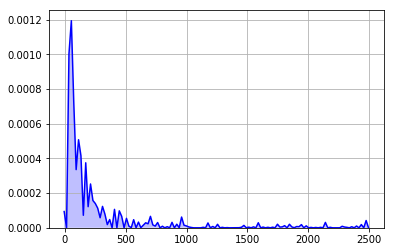

In [20]:
temp_data = df_train_mv['f37'][df_train_mv['f37'] < df_train_mv['f37'].mean() + 1*df_train_mv['f37'].std()]
sns.kdeplot(temp_data.values, color='blue', shade=True)
plt.grid(True)
sns.reset_orig()

In [21]:
for col in df_train_mv.columns:
    temp = df_train_mv[col].isnull().sum()
    if temp != 0:
        print("%s : Nb. of NaN = %s" % (col, df_train_mv[col].isnull().sum()))
print('Check.')

Check.


In [22]:
for col in df_test_mv.columns:
    temp = df_test_mv[col].isnull().sum()
    if temp != 0:
        print("%s : Nb. of NaN = %s" % (col, df_test_mv[col].isnull().sum()))
print('Check.')

Check.


### <font color='green'> 2.2. Outliers </font>

**Outliers** are the second feature engineering problem we are going to be deal with. We dealing here with "single data points", which are further away than the rest of the distribution.

References:
- https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561
- http://scikit-learn.org/stable/modules/outlier_detection.html#

There are a couple of methods to deal with outliers:

- *Z-Scores*
- *Dbscan* (Density Based Spatial Clustering of Applications with Noise)
- *Isolation Forest*

We will be using anomaly detection algorithms, here specifically **isolation forests** (developped by Fei Tony Liu, Kai Ming Ting and Zhi-Hua Zhou). For each feature, we assume that $\gamma = 1\%$ of the datapoints are outliers. This rule is automated for each of the 62 features. Then for the datapoints classified as outliers, we map them as NaN missing values and then exclude them. 

In [27]:
df_train_mvo = copy(df_train_mv)
df_test_mvo = copy(df_test_mv)

In [28]:
import warnings
warnings.filterwarnings("ignore")

outliers = []
from sklearn.ensemble import IsolationForest

gamma = 0.005
for n in range(len(df_train_mvo.drop('label', axis=1).columns)):
    
    # OUTLIER DETECTION
    # print(df_train_mv.columns[n])
    temp = df_train_mvo.iloc[:,n]
    temp_model = IsolationForest(contamination=gamma).fit(temp.reshape(-1,1))
    temp_pred = temp_model.predict(temp.reshape(-1,1))
    
    # COUNT NB. OUTLIERS
    # temp_nb_outliers = len(temp_pred)
    # outliers.append(temp_nb_outliers)
    
    # Modify
    for i in range(len(df_train_mvo)):
        if temp_pred[i]==-1:
            df_train_mvo.iloc[i,n] = np.nan

In [29]:
for col in df_train_mvo.columns:
    temp = df_train_mvo[col].isnull().sum()
    if temp != 0:
        print("%s : Nb. of NaN = %s" % (col, df_train_mvo[col].isnull().sum()))
print('Check.')

f1 : Nb. of NaN = 39
f2 : Nb. of NaN = 36
f3 : Nb. of NaN = 36
f4 : Nb. of NaN = 38
f5 : Nb. of NaN = 39
f6 : Nb. of NaN = 38
f7 : Nb. of NaN = 38
f8 : Nb. of NaN = 37
f9 : Nb. of NaN = 38
f10 : Nb. of NaN = 36
f11 : Nb. of NaN = 38
f12 : Nb. of NaN = 37
f13 : Nb. of NaN = 36
f14 : Nb. of NaN = 39
f15 : Nb. of NaN = 37
f16 : Nb. of NaN = 37
f17 : Nb. of NaN = 37
f18 : Nb. of NaN = 36
f19 : Nb. of NaN = 37
f20 : Nb. of NaN = 36
f22 : Nb. of NaN = 36
f23 : Nb. of NaN = 36
f24 : Nb. of NaN = 37
f25 : Nb. of NaN = 36
f26 : Nb. of NaN = 36
f28 : Nb. of NaN = 36
f29 : Nb. of NaN = 36
f30 : Nb. of NaN = 36
f31 : Nb. of NaN = 36
f32 : Nb. of NaN = 36
f33 : Nb. of NaN = 36
f34 : Nb. of NaN = 36
f35 : Nb. of NaN = 36
f36 : Nb. of NaN = 37
f37 : Nb. of NaN = 38
f38 : Nb. of NaN = 36
f39 : Nb. of NaN = 36
f40 : Nb. of NaN = 36
f41 : Nb. of NaN = 36
f42 : Nb. of NaN = 36
f43 : Nb. of NaN = 36
f44 : Nb. of NaN = 36
f45 : Nb. of NaN = 42
f46 : Nb. of NaN = 37
f47 : Nb. of NaN = 36
f48 : Nb. of NaN = 

In [32]:
# for col in features_abv:
#     df_train_mvo[col] = df_train_mvo[col].fillna(df_train_mvo[col].median())
#     df_test_mvo[col] = df_train_mvo[col].fillna(df_train_mvo[col].median())

We drop those outliers:

In [33]:
df_train_mvo = df_train_mvo.dropna()
df_test_mvo = df_test_mvo.dropna()
print(df_train_mvo.shape)
print(df_test_mvo.shape)

(6329, 63)
(3466, 62)


### <font color='green'> 2.3. Multicollinearity </font>

**Multicollinearity** is an issue for machine learning problems as it will create "ridges" in the cost function. This introduces instability in model learning. We can use the variance inflation factor which quantifies multicollinearity in a dataset. Features with a VIF of over 10 are usually excluded in linear regression problems, but here we will use regularization penalties and ensemble learning to deal with the instability of model learning.

In [34]:
df_train_out = copy(df_train_mvo)
df_test_out = copy(df_test_mvo)

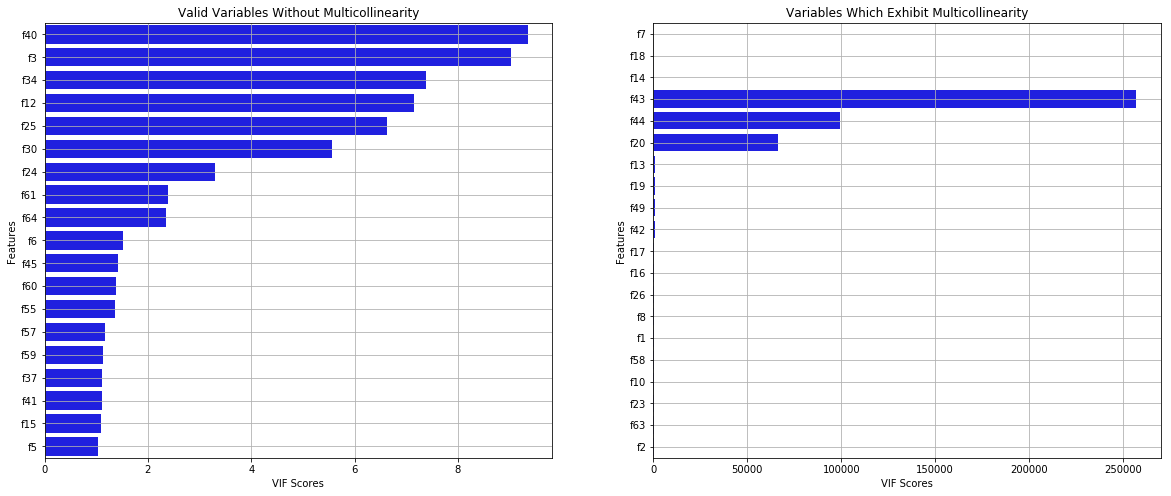

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

numericalCol = []
for f in features_abv:
    #print (f)
    if df_train_out[f].dtype!='object' and f not in ["parcelid", "transactiondate", "logerror"]:
        numericalCol.append(f)
mergedFilterd = df_train_out[numericalCol].fillna(-999)
vifDict = calculate_vif_(mergedFilterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=10]
variablesWithMC  = vifDf[vifDf["vifScore"]>10]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sns.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h", color='blue')
sns.barplot(data=variablesWithMC.head(20),x="vifScore",y="variables",ax=ax2,orient="h", color='blue')
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")
ax1.grid(True)
ax2.grid(True)
sns.reset_orig()

In [36]:
print(len(variablesWithMC))
print(len(validVariables))

43
19


In [ ]:
# multicolinear_vars = variablesWithMC['variables'].values
# df_train_out = df_train_out.drop(multicolinear_vars, axis=1)
# df_test_out = df_test_out.drop(multicolinear_vars, axis=1)

In [37]:
df_train_cc = copy(df_train_out)
df_test_cc = copy(df_test_out)
print(df_train_cc.shape)

(6329, 63)


### <font color='green'> 2.4. Creating new features <font>

**Polynomial features**

This function was created to automatically create multiple polynomial and interaction terms on a given dataset. Due to time constraints, this ended being an unexplored option but would have probably helped go over 90% ROC AUC.

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def polynomial_features(X, p, option='2'):
    """
    Create a matrix of polynomial features. Options include
    x**p only (1), interaction terms only (2) or both (3).
    """
    standardizer = Pipeline([('scaler', RobustScaler())])
    
    if option == '2' or option == '3':
        option2 = False
        if option == '2':
            option2 = True
        poly = PolynomialFeatures(p, interaction_only=option2, include_bias=False)
        X = poly.fit_transform(X)
        X = standardizer.fit_transform(X)
        # X = pd.DataFrame(X, columns=['sq^%s' % p for p in range(0,p+1)])
        X = pd.DataFrame(X)
    else:
        X = np.hstack((X**(i+1) for i in range(X.shape[1])))
    return X

In [39]:
test_1 = polynomial_features(df_train_cc.drop('label', axis=1), 2, option='2')
test_2 = polynomial_features(df_test_cc, 2, option='2')
print(test_1.shape)
print(test_2.shape)

(6329, 1953)
(3466, 1953)


In [40]:
print(df_train_cc.shape)
print(df_test_cc.shape)

(6329, 63)
(3466, 62)


### <font color='green'> 2.5. Output corrected train and test datasets <font>

This will be the dataset used for the model learning.

In [42]:
print(df_train_cc.shape)
print(df_test_cc.shape)

(6329, 63)
(3466, 62)


In [43]:
df_train_cc.to_csv('ML_train.csv')
df_test_cc.to_csv('ML_test.csv')